In [1]:
%matplotlib inline  

from io import StringIO
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
import numpy as np
from gcloud import bigquery
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn

In [2]:
path = r"E:\Data\Securities\amex-nyse-nasdaq-stock-histories\fh_20190420\full_history"
security = "AAPL"
df = pd.read_csv(r"{}\{}.csv".format(path,security))
df = df.sort_index(axis=0, ascending=False).reset_index().drop(columns=['index'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
df_combined = pd.DataFrame()

In [3]:
closing_data = pd.DataFrame()
closing_data['close'] = df['close']
df_combined['close'] = closing_data['close']

C:\Users\ken\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


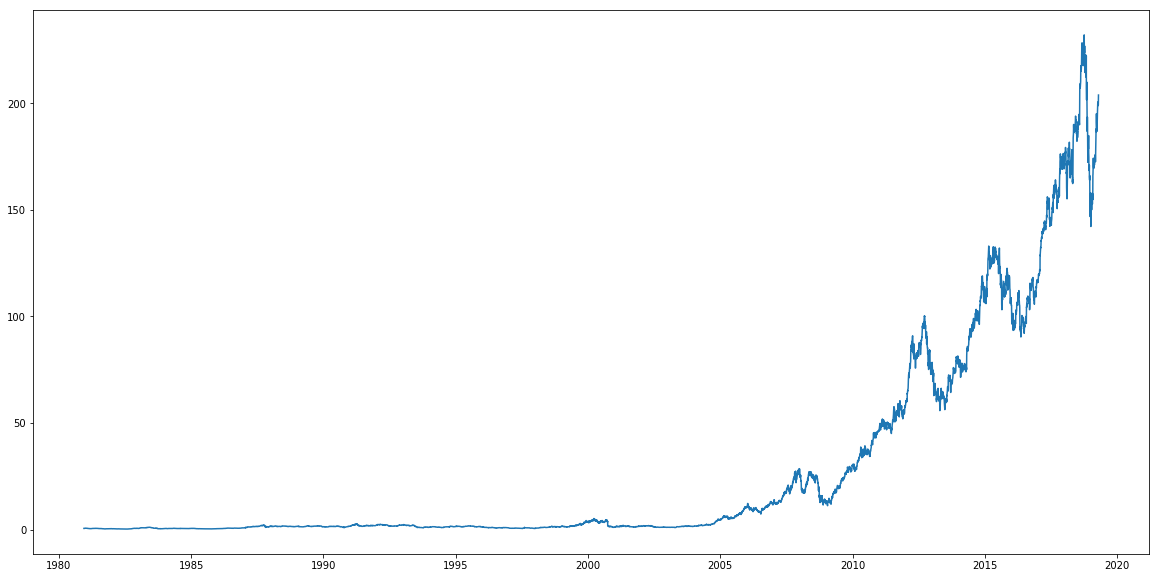

In [4]:
plt.figure(figsize=(20,10))
plt.plot(closing_data)

In [5]:
from sklearn import preprocessing

x = closing_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
closing_data['close_scaled'] = x_scaled

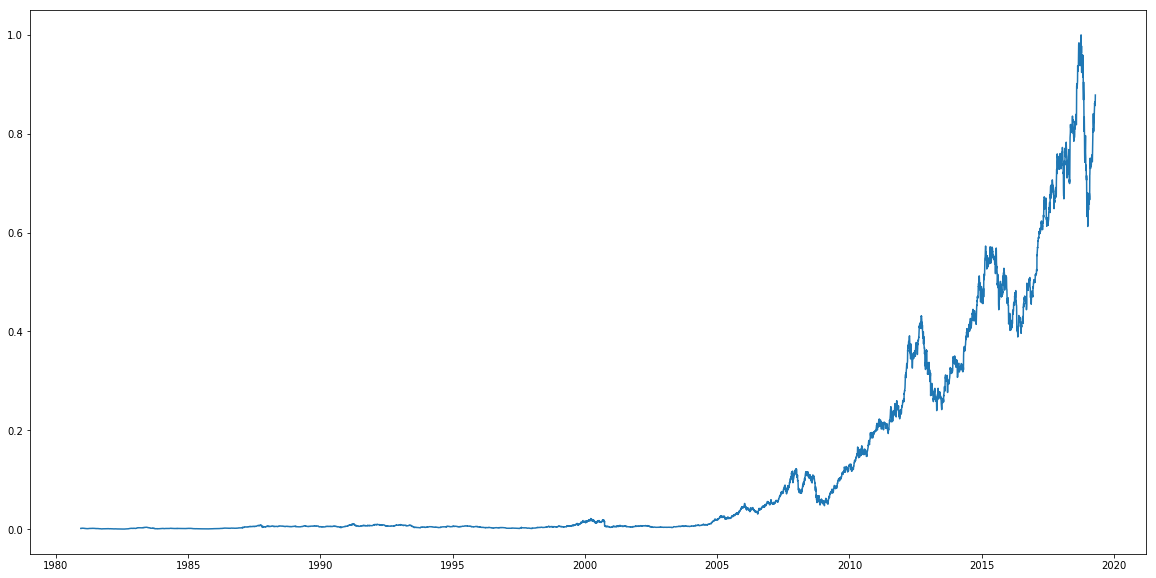

In [6]:
plt.figure(figsize=(20,10))
plt.plot(closing_data.index, closing_data['close_scaled'])

Normalize daily log returns

ln(Vt/Vt-1)

In [7]:
log_return_data = pd.DataFrame()
log_return_data['log_return'] = np.log(closing_data['close']/closing_data['close'].shift())

In [8]:
log_return_data = log_return_data.fillna(method='ffill')

In [9]:
x = log_return_data.values
min_max_scaler_log_return = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_log_return.fit_transform(x)
log_return_data['log_return_scaled'] = x_scaled

In [10]:
df_combined['log_return'] = log_return_data['log_return']

Metrics

Acceleration

In [11]:
log_accel_data = pd.DataFrame()
log_accel_data['acceleration'] = log_return_data['log_return'] - log_return_data['log_return'].shift()
df_combined['acceleration'] = log_accel_data['acceleration'] 

Normalized acceleration

In [13]:
x = log_accel_data.values
min_max_scaler_accel = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_accel.fit_transform(x)
log_accel_data['acceleration_scaled'] = x_scaled
log_accel_data.head()

,acceleration,acceleration_scaled
date,,
1980-12-12,NaN,NaN
1980-12-15,NaN,NaN
1980-12-16,-0.022643,0.534818
1980-12-17,0.100678,0.617494
1980-12-18,0.004122,0.552762


In [14]:
log_accel_data.describe()

,acceleration,acceleration_scaled
count,9667.000000,9667.000000
mean,0.000006,0.550002
std,0.040907,0.027425
min,-0.820385,0.000000
25%,-0.020031,0.536569
50%,-0.000396,0.549733
75%,0.019867,0.563317
max,0.671229,1.000000


Calculate Exponential Moving Averages

In [15]:
exponential_moving_averages = pd.DataFrame()
exponential_moving_averages['4ema'] = closing_data['close'].ewm(span=4).mean()
exponential_moving_averages['7ema'] = closing_data['close'].ewm(span=7).mean()
exponential_moving_averages['14ema'] = closing_data['close'].ewm(span=14).mean()
exponential_moving_averages['4ema_7ema'] = np.log(exponential_moving_averages['4ema'] / exponential_moving_averages['7ema'])
exponential_moving_averages.head()

,4ema,7ema,14ema,4ema_7ema
date,,,,
1980-12-12,0.513393,0.513393,0.513393,0.000000
1980-12-15,0.496652,0.498087,0.499043,-0.002885
1980-12-16,0.473305,0.477679,0.480650,-0.009197
1980-12-17,0.468135,0.471964,0.474961,-0.008148
1980-12-18,0.471306,0.473106,0.475087,-0.003811


In [16]:
df_combined['4ema'] = exponential_moving_averages['4ema'] 
df_combined['7ema'] = exponential_moving_averages['7ema'] 
df_combined['14ema'] = exponential_moving_averages['14ema'] 
df_combined['4ema_7ema'] = exponential_moving_averages['4ema_7ema'] 

In [17]:
exponential_moving_averages.describe()

,4ema,7ema,14ema,4ema_7ema
count,9669.000000,9669.000000,9669.000000,9669.000000
mean,27.415096,27.384220,27.313544,0.000588
std,48.451030,48.398217,48.278485,0.013842
min,0.204616,0.209401,0.217418,-0.198170
25%,1.054529,1.053839,1.053368,-0.006183
50%,1.674594,1.673792,1.668471,0.001305
75%,26.835929,26.700108,26.446492,0.008286
max,228.896919,227.163465,225.018535,0.095598


In [18]:
x_scaled

array([[       nan,        nan],
       [       nan,        nan],
       [0.53481788, 0.53481788],
       ...,
       [0.54885292, 0.54885292],
       [0.56286034, 0.56286034],
       [0.53947356, 0.53947356]])

In [19]:
x_scaled[:,1]

array([       nan,        nan, 0.53481788, ..., 0.54885292, 0.56286034,
       0.53947356])

In [20]:
x = exponential_moving_averages.values
min_max_scaler_ema = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_ema.fit_transform(x)
exponential_moving_averages['4ema_scaled'] = x_scaled[:,0]
exponential_moving_averages['7ema_scaled'] = x_scaled[:,1]
exponential_moving_averages['14ema_scaled']  = x_scaled[:,2]
exponential_moving_averages['4ema_7ema_scaled'] = x_scaled[:,3]

Calculate Daily Log Return of EMA

In [21]:
ema_log_return = pd.DataFrame()
ema_log_return['4ema'] = np.log(exponential_moving_averages['4ema']/exponential_moving_averages['4ema'].shift())
ema_log_return['7ema'] = np.log(exponential_moving_averages['7ema']/exponential_moving_averages['7ema'].shift())
ema_log_return.head()

,4ema,7ema
date,,
1980-12-12,NaN,NaN
1980-12-15,-0.033152,-0.030267
1980-12-16,-0.048148,-0.041836
1980-12-17,-0.010985,-0.012035
1980-12-18,0.006752,0.002415


In [22]:
df_combined['4ema_log_return'] = ema_log_return['4ema']
df_combined['7ema_log_return'] = ema_log_return['7ema']

Calculate EMA acceleration

In [23]:
ema_accel = pd.DataFrame()
ema_accel['4ema1'] = ema_log_return['4ema'] - ema_log_return['4ema'].shift()
ema_accel['7ema1'] = ema_log_return['7ema'] - ema_log_return['7ema'].shift()
ema_accel.head()

,4ema1,7ema1
date,,
1980-12-12,NaN,NaN
1980-12-15,NaN,NaN
1980-12-16,-0.014996,-0.011569
1980-12-17,0.037163,0.029801
1980-12-18,0.017737,0.014450


In [24]:
df_combined['4ema_acceleration'] = ema_accel['4ema1']
df_combined['7ema_acceleration'] = ema_accel['7ema1']

Calculate Relative Position of close to ema

In [25]:
ema_data_posit = pd.DataFrame()
ema_data_posit['posit_to_4ema'] = np.log(closing_data['close'] / exponential_moving_averages['4ema'])
ema_data_posit['posit_to_7ema'] = np.log(closing_data['close'] / exponential_moving_averages['7ema'])
ema_data_posit.head()

,posit_to_4ema,posit_to_7ema
date,,
1980-12-12,0.000000,0.000000
1980-12-15,-0.020432,-0.023317
1980-12-16,-0.048511,-0.057708
1980-12-17,-0.013075,-0.021222
1980-12-18,0.008747,0.004935


In [26]:
df_combined['posit_to_4ema'] = ema_data_posit['posit_to_4ema'] 
df_combined['posit_to_7ema'] = ema_data_posit['posit_to_7ema']

In [27]:
ema_data_posit_accel = pd.DataFrame()
ema_data_posit_accel['posit_to_4ema_accel'] = ema_data_posit['posit_to_4ema'] - ema_data_posit['posit_to_4ema'].shift()
ema_data_posit_accel['posit_to_7ema_accel'] = ema_data_posit['posit_to_7ema'] - ema_data_posit['posit_to_7ema'].shift()
ema_data_posit_accel.head()

,posit_to_4ema_accel,posit_to_7ema_accel
date,,
1980-12-12,NaN,NaN
1980-12-15,-0.020432,-0.023317
1980-12-16,-0.028079,-0.034391
1980-12-17,0.035436,0.036486
1980-12-18,0.021822,0.026158


In [28]:
df_combined['posit_to_4ema_accel'] = ema_data_posit_accel['posit_to_4ema_accel'] 
df_combined['posit_to_7ema_accel'] = ema_data_posit_accel['posit_to_7ema_accel'] 

11 Min https://www.youtube.com/watch?v=w1xXI4-l1D8&list=LLURbf3UcR1sStZIs1rUyNNw&index=2&t=23s

Simple Moving Averages (SMA) & Bollinger Bands

In [29]:
sma_data = pd.DataFrame()
sma_data['3sma'] = closing_data['close'].rolling(min_periods=1, window=3, center=False).mean()
sma_data['4sma'] = closing_data['close'].rolling(min_periods=1, window=4, center=False).mean()
sma_data['6sma'] = closing_data['close'].rolling(min_periods=1, window=6, center=False).mean()

In [30]:
df_combined['3sma'] = sma_data['3sma']
df_combined['4sma'] = sma_data['4sma']
df_combined['6sma'] = sma_data['6sma']

Calculate Stds

In [31]:
std_data = pd.DataFrame()
std_data['3std'] = closing_data['close'].rolling(min_periods=1, window=3, center=False).std()
std_data['6std'] = closing_data['close'].rolling(min_periods=1, window=6, center=False).std()

In [32]:
df_combined['3std'] = std_data['3std']
df_combined['6std'] = std_data['6std']

Calculate Bollinger Bands

In [33]:
bb_data = pd.DataFrame()
bb_data['6upperBand'] = sma_data['6sma'] + (1.6*std_data['6std'])
bb_data['6lowerBand'] = sma_data['6sma'] - (1.6*std_data['6std'])
bb_data['6pctB'] = (closing_data['close'] - bb_data['6lowerBand']) / (bb_data['6upperBand'] - bb_data['6lowerBand'])

In [34]:
df_combined['6upperBand'] = bb_data['6upperBand'] 
df_combined['6lowerBand'] = bb_data['6lowerBand'] 
df_combined['6pctB'] = bb_data['6pctB'] 

Day to day change of %B

In [35]:
bb_data['PChg6pctB'] = bb_data['6pctB'] - bb_data['6pctB'].shift()

In [36]:
bb_data['posit_to_u6BB'] = -np.log(closing_data['close'] / bb_data['6upperBand'])
bb_data['posit_tol6BB'] = -np.log(closing_data['close'] / bb_data['6lowerBand'])

In [37]:
bb_data.head()

,6upperBand,6lowerBand,6pctB,PChg6pctB,posit_to_u6BB,posit_tol6BB
date,,,,,,
1980-12-12,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.530305,0.469695,0.279029,NaN,0.085994,-0.035373
1980-12-16,0.533801,0.433461,0.173727,-0.105302,0.168793,-0.039428
1980-12-17,0.522689,0.433785,0.317972,0.144245,0.123305,-0.063133
1980-12-18,0.516227,0.439130,0.471047,0.153076,0.082292,-0.079458


In [38]:
df_combined['PChg6pctB'] = bb_data['PChg6pctB']
df_combined['posit_to_u6BB'] = bb_data['posit_to_u6BB']
df_combined['posit_tol6BB'] = bb_data['posit_tol6BB']

In [39]:
df_combined

,close,log_return,acceleration,4ema,7ema,14ema,4ema_7ema,4ema_log_return,7ema_log_return,4ema_acceleration,...,4sma,6sma,3std,6std,6upperBand,6lowerBand,6pctB,PChg6pctB,posit_to_u6BB,posit_tol6BB
date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.513393,NaN,NaN,0.513393,0.513393,0.513393,0.000000,NaN,NaN,NaN,...,0.513393,0.513393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.486607,-0.053584,NaN,0.496652,0.498087,0.499043,-0.002885,-0.033152,-0.030267,NaN,...,0.500000,0.500000,0.018940,0.018940,0.530305,0.469695,0.279029,NaN,0.085994,-0.035373
1980-12-16,0.450893,-0.076227,-0.022643,0.473305,0.477679,0.480650,-0.009197,-0.048148,-0.041836,-0.014996,...,0.483631,0.483631,0.031356,0.031356,0.533801,0.433461,0.173727,-0.105302,0.168793,-0.039428
1980-12-17,0.462054,0.024451,0.100678,0.468135,0.471964,0.474961,-0.008148,-0.010985,-0.012035,0.037163,...,0.478237,0.478237,0.018271,0.027782,0.522689,0.433785,0.317972,0.144245,0.123305,-0.063133
1980-12-18,0.475446,0.028573,0.004122,0.471306,0.473106,0.475087,-0.003811,0.006752,0.002415,0.017737,...,0.468750,0.477679,0.012294,0.024093,0.516227,0.439130,0.471047,0.153076,0.082292,-0.079458
1980-12-19,0.504464,0.059243,0.030669,0.485218,0.482643,0.481885,0.005322,0.029092,0.019958,0.022340,...,0.473214,0.482143,0.021680,0.024165,0.520807,0.443479,0.788660,0.317612,0.031882,-0.128847
1980-12-22,0.529018,0.047525,-0.011718,0.503243,0.496022,0.491817,0.014451,0.036474,0.027345,0.007382,...,0.492746,0.484747,0.026817,0.028635,0.530563,0.438931,0.983142,0.194483,0.002916,-0.186679
1980-12-23,0.551339,0.041328,-0.006197,0.522810,0.511390,0.503458,0.022085,0.038146,0.030512,0.001672,...,0.515067,0.495536,0.023446,0.039579,0.558862,0.432210,0.940604,-0.042538,0.013552,-0.243440
1980-12-24,0.580357,0.051293,0.009965,0.546063,0.530032,0.517617,0.029798,0.043517,0.035804,0.005371,...,0.541295,0.517113,0.025742,0.045256,0.589523,0.444703,0.936708,-0.003896,0.015670,-0.266237


In [40]:
x = df_combined.values
min_max_scaler_all = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_all.fit_transform(x)

In [41]:
df_scaled = pd.DataFrame(x_scaled, columns=df_combined.columns ,index=df_combined.index)

In [42]:
df_scaled

,close,log_return,acceleration,4ema,7ema,14ema,4ema_7ema,4ema_log_return,7ema_log_return,4ema_acceleration,...,4sma,6sma,3std,6std,6upperBand,6lowerBand,6pctB,PChg6pctB,posit_to_u6BB,posit_tol6BB
date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.001367,NaN,NaN,0.001350,0.001339,0.001317,0.674579,NaN,NaN,NaN,...,0.001358,0.001353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.001251,0.665590,NaN,0.001277,0.001272,0.001253,0.664758,0.527608,0.450179,NaN,...,0.001299,0.001294,0.001782,0.001861,0.001352,0.001242,0.325913,NaN,0.120985,0.815525
1980-12-16,0.001097,0.643351,0.534818,0.001175,0.001182,0.001171,0.643272,0.486919,0.402200,0.630521,...,0.001228,0.001222,0.002951,0.003159,0.001367,0.001080,0.243162,0.440564,0.199149,0.811718
1980-12-17,0.001146,0.742236,0.617494,0.001152,0.001157,0.001146,0.646845,0.587754,0.525792,0.775872,...,0.001204,0.001199,0.001719,0.002785,0.001319,0.001081,0.356516,0.552273,0.156207,0.789462
1980-12-18,0.001203,0.746285,0.552762,0.001166,0.001162,0.001146,0.661605,0.635880,0.585720,0.721737,...,0.001163,0.001196,0.001157,0.002399,0.001292,0.001105,0.476810,0.556227,0.117490,0.774134
1980-12-19,0.001328,0.776408,0.570559,0.001227,0.001204,0.001176,0.692697,0.696495,0.658472,0.734564,...,0.001182,0.001216,0.002040,0.002407,0.001311,0.001124,0.726403,0.629881,0.069901,0.727764
1980-12-22,0.001434,0.764899,0.542142,0.001306,0.001263,0.001221,0.723772,0.716525,0.689106,0.692881,...,0.001267,0.001227,0.002524,0.002874,0.001353,0.001104,0.879237,0.574762,0.042556,0.673467
1980-12-23,0.001531,0.758812,0.545844,0.001391,0.001331,0.001272,0.749758,0.721061,0.702240,0.676969,...,0.001365,0.001275,0.002206,0.004019,0.001474,0.001074,0.845808,0.468661,0.052597,0.620175
1980-12-24,0.001656,0.768600,0.556679,0.001493,0.001413,0.001335,0.776013,0.735635,0.724188,0.687278,...,0.001479,0.001369,0.002422,0.004613,0.001606,0.001130,0.842747,0.485959,0.054597,0.598771


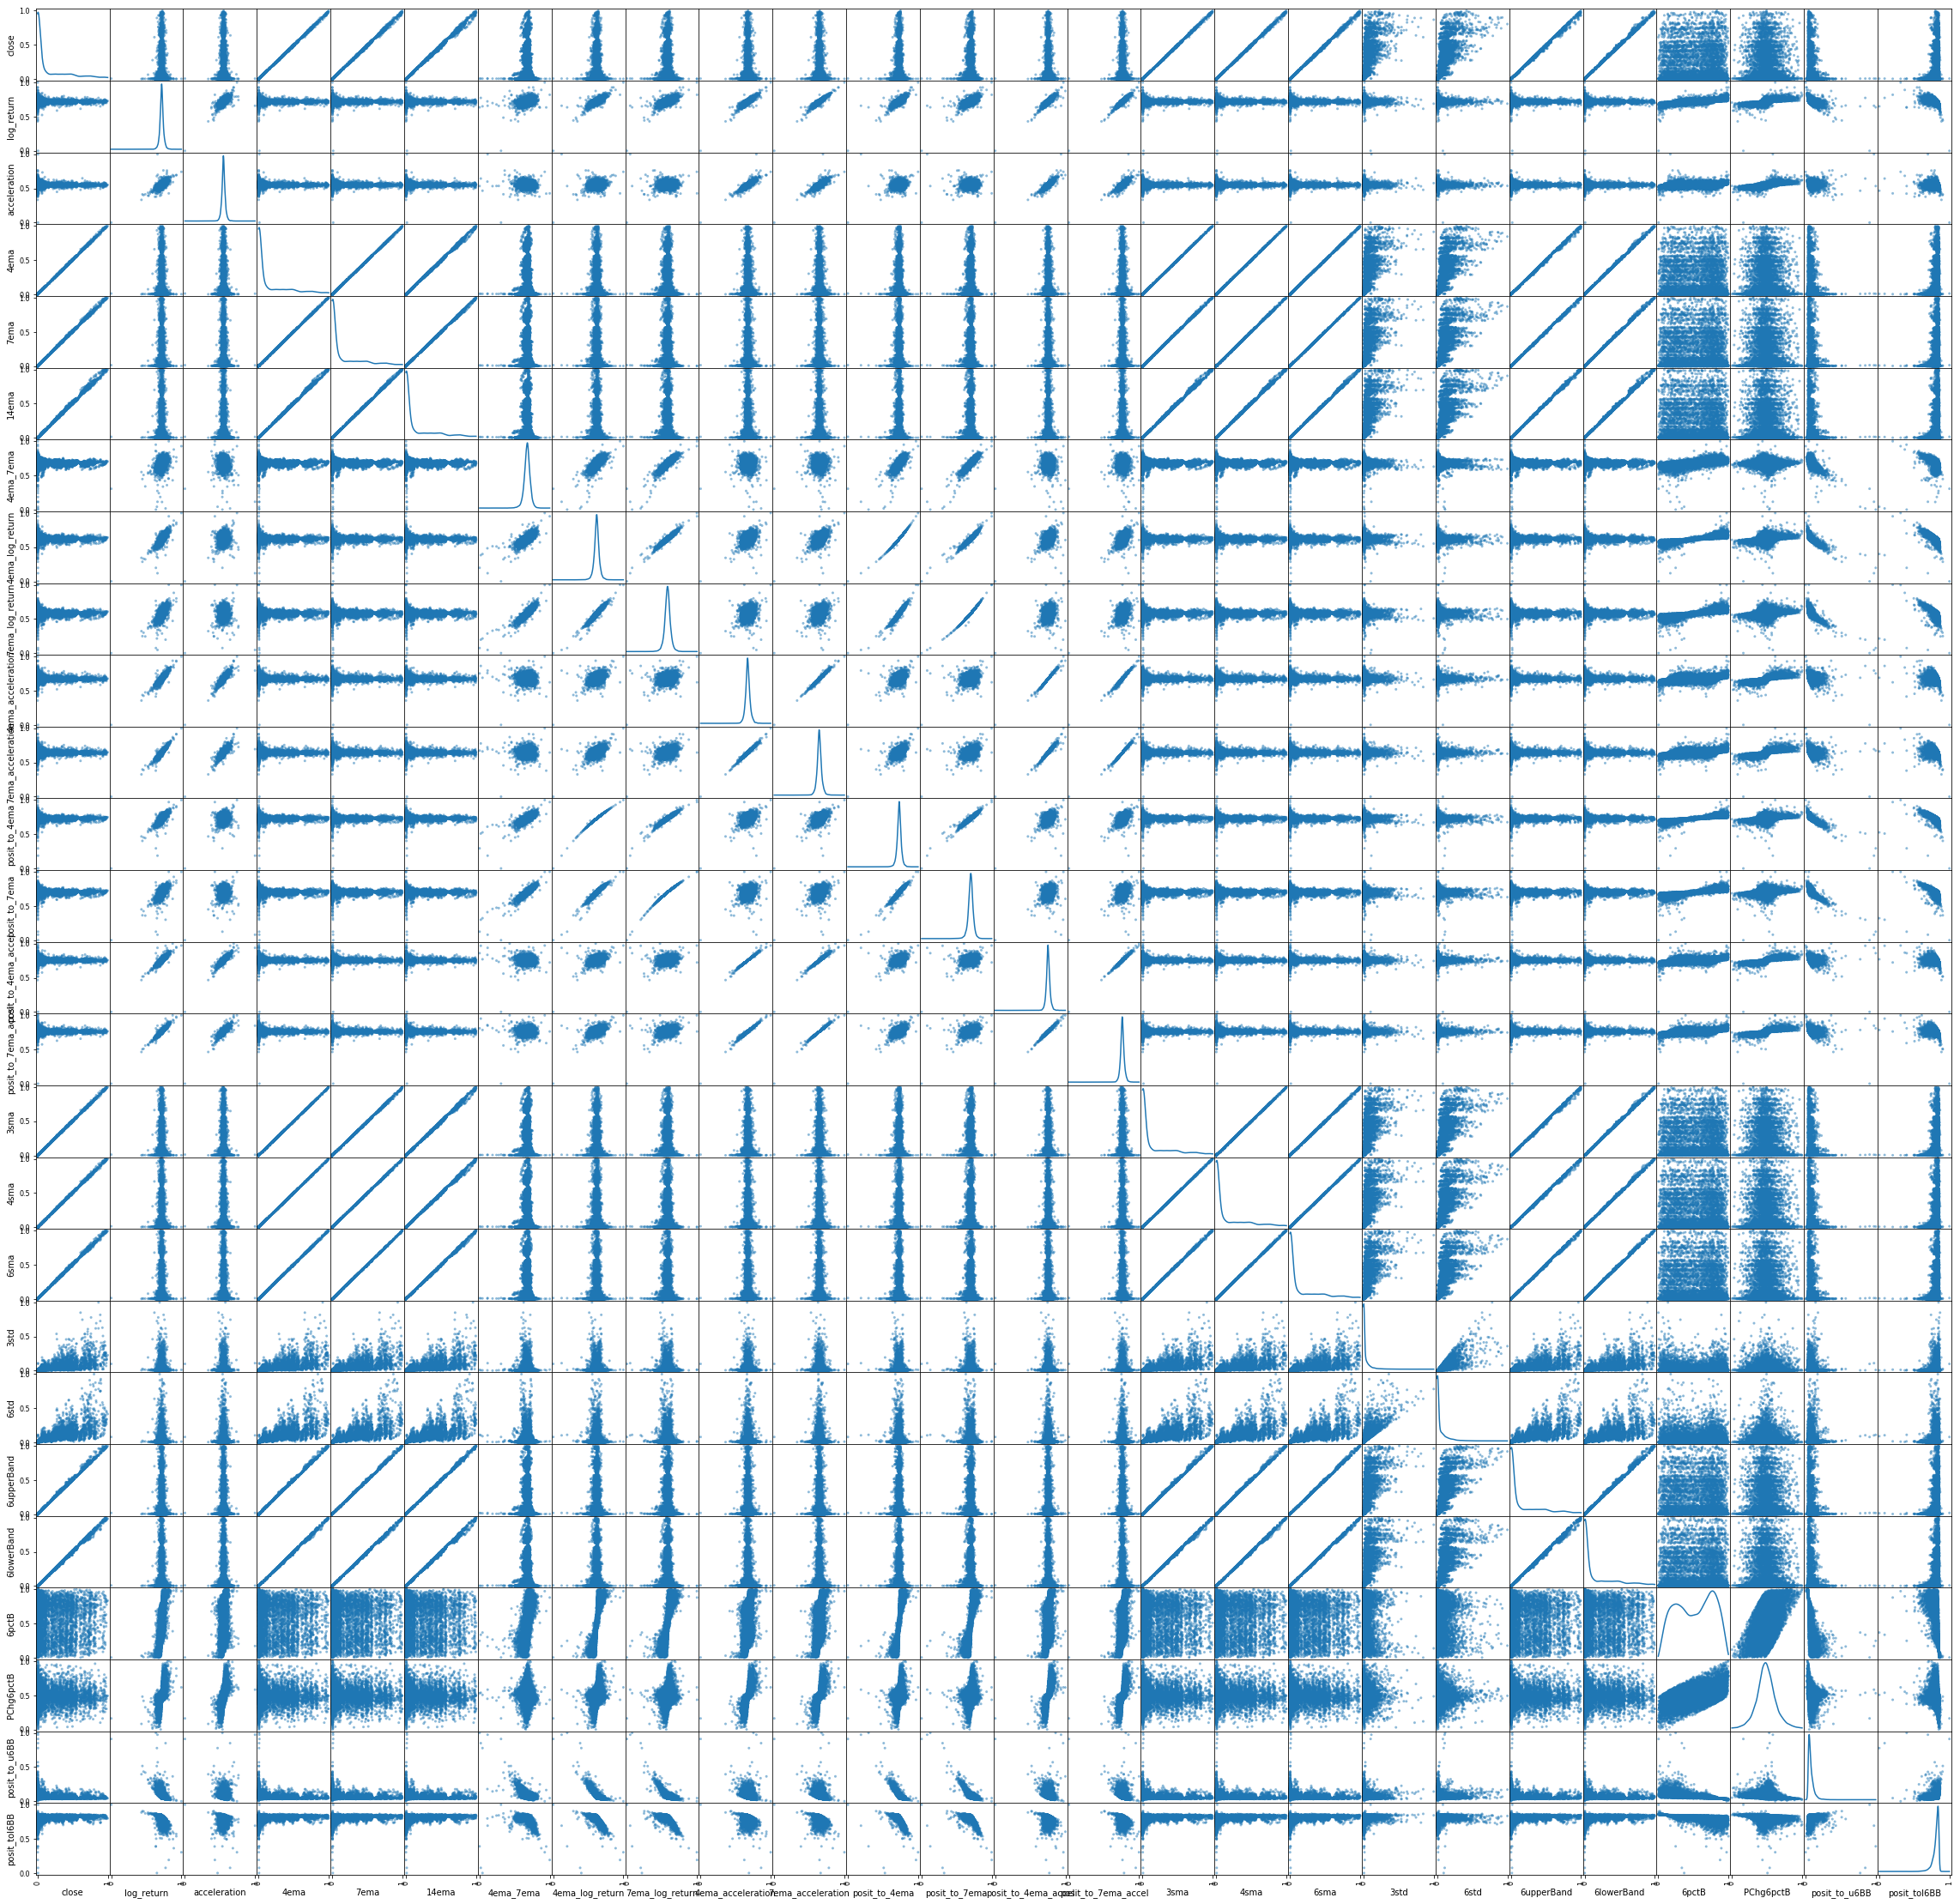

In [43]:
_ = scatter_matrix(df_scaled, figsize=(40,40), diagonal='kde')

In [46]:
df_combined['label'] = (df_combined['log_return'] > 0).astype(int)
df_combined['label'] = df_combined['label'].shift(-1)
df_combined

,close,log_return,acceleration,4ema,7ema,14ema,4ema_7ema,4ema_log_return,7ema_log_return,4ema_acceleration,...,6sma,3std,6std,6upperBand,6lowerBand,6pctB,PChg6pctB,posit_to_u6BB,posit_tol6BB,label
date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.513393,NaN,NaN,0.513393,0.513393,0.513393,0.000000,NaN,NaN,NaN,...,0.513393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1980-12-15,0.486607,-0.053584,NaN,0.496652,0.498087,0.499043,-0.002885,-0.033152,-0.030267,NaN,...,0.500000,0.018940,0.018940,0.530305,0.469695,0.279029,NaN,0.085994,-0.035373,0.0
1980-12-16,0.450893,-0.076227,-0.022643,0.473305,0.477679,0.480650,-0.009197,-0.048148,-0.041836,-0.014996,...,0.483631,0.031356,0.031356,0.533801,0.433461,0.173727,-0.105302,0.168793,-0.039428,1.0
1980-12-17,0.462054,0.024451,0.100678,0.468135,0.471964,0.474961,-0.008148,-0.010985,-0.012035,0.037163,...,0.478237,0.018271,0.027782,0.522689,0.433785,0.317972,0.144245,0.123305,-0.063133,1.0
1980-12-18,0.475446,0.028573,0.004122,0.471306,0.473106,0.475087,-0.003811,0.006752,0.002415,0.017737,...,0.477679,0.012294,0.024093,0.516227,0.439130,0.471047,0.153076,0.082292,-0.079458,1.0
1980-12-19,0.504464,0.059243,0.030669,0.485218,0.482643,0.481885,0.005322,0.029092,0.019958,0.022340,...,0.482143,0.021680,0.024165,0.520807,0.443479,0.788660,0.317612,0.031882,-0.128847,1.0
1980-12-22,0.529018,0.047525,-0.011718,0.503243,0.496022,0.491817,0.014451,0.036474,0.027345,0.007382,...,0.484747,0.026817,0.028635,0.530563,0.438931,0.983142,0.194483,0.002916,-0.186679,1.0
1980-12-23,0.551339,0.041328,-0.006197,0.522810,0.511390,0.503458,0.022085,0.038146,0.030512,0.001672,...,0.495536,0.023446,0.039579,0.558862,0.432210,0.940604,-0.042538,0.013552,-0.243440,1.0
1980-12-24,0.580357,0.051293,0.009965,0.546063,0.530032,0.517617,0.029798,0.043517,0.035804,0.005371,...,0.517113,0.025742,0.045256,0.589523,0.444703,0.936708,-0.003896,0.015670,-0.266237,1.0


In [85]:
df_scaled['label'] = df_combined['label']
df_scaled

,close,log_return,acceleration,4ema,7ema,14ema,4ema_7ema,4ema_log_return,7ema_log_return,4ema_acceleration,...,6sma,3std,6std,6upperBand,6lowerBand,6pctB,PChg6pctB,posit_to_u6BB,posit_tol6BB,label
date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.001367,NaN,NaN,0.001350,0.001339,0.001317,0.674579,NaN,NaN,NaN,...,0.001353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1980-12-15,0.001251,0.665590,NaN,0.001277,0.001272,0.001253,0.664758,0.527608,0.450179,NaN,...,0.001294,0.001782,0.001861,0.001352,0.001242,0.325913,NaN,0.120985,0.815525,0.0
1980-12-16,0.001097,0.643351,0.534818,0.001175,0.001182,0.001171,0.643272,0.486919,0.402200,0.630521,...,0.001222,0.002951,0.003159,0.001367,0.001080,0.243162,0.440564,0.199149,0.811718,1.0
1980-12-17,0.001146,0.742236,0.617494,0.001152,0.001157,0.001146,0.646845,0.587754,0.525792,0.775872,...,0.001199,0.001719,0.002785,0.001319,0.001081,0.356516,0.552273,0.156207,0.789462,1.0
1980-12-18,0.001203,0.746285,0.552762,0.001166,0.001162,0.001146,0.661605,0.635880,0.585720,0.721737,...,0.001196,0.001157,0.002399,0.001292,0.001105,0.476810,0.556227,0.117490,0.774134,1.0
1980-12-19,0.001328,0.776408,0.570559,0.001227,0.001204,0.001176,0.692697,0.696495,0.658472,0.734564,...,0.001216,0.002040,0.002407,0.001311,0.001124,0.726403,0.629881,0.069901,0.727764,1.0
1980-12-22,0.001434,0.764899,0.542142,0.001306,0.001263,0.001221,0.723772,0.716525,0.689106,0.692881,...,0.001227,0.002524,0.002874,0.001353,0.001104,0.879237,0.574762,0.042556,0.673467,1.0
1980-12-23,0.001531,0.758812,0.545844,0.001391,0.001331,0.001272,0.749758,0.721061,0.702240,0.676969,...,0.001275,0.002206,0.004019,0.001474,0.001074,0.845808,0.468661,0.052597,0.620175,1.0
1980-12-24,0.001656,0.768600,0.556679,0.001493,0.001413,0.001335,0.776013,0.735635,0.724188,0.687278,...,0.001369,0.002422,0.004613,0.001606,0.001130,0.842747,0.485959,0.054597,0.598771,1.0


In [184]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Sequential, Input, callbacks

In [71]:
def model_Sec(input_shape):
    inputs = Input(shape=(input_shape,), name='input')
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    return model

In [104]:
train_data = df_combined[5000:8000].drop(columns=['label'])
train_label = df_combined['label'][5000:8000]

In [105]:
test_data = df_combined[8000:].drop(columns=['label'])
test_label= df_combined['label'][8000:]

In [106]:
train_data.values.shape[1]

26

In [158]:
model = model_Sec(train_data.values.shape[1])
model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adagrad(),
              metrics=[tf.metrics.AUC()])

In [159]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 26)]              0         
_________________________________________________________________
batch_normalization_v2_24 (B (None, 26)                104       
_________________________________________________________________
dense_37 (Dense)             (None, 256)               6912      
_________________________________________________________________
batch_normalization_v2_25 (B (None, 256)               1024      
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 514       
Total params: 8,554
Trainable params: 7,990
Non-trainable params: 564
_________________________________________________________________


In [166]:
from tensorflow.keras.utils import to_categorical
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

In [175]:
#tensorboard = TensorBoard(log_dir=r"E:\logs\{}".format(time()), histogram_freq=1, tf.me)

In [177]:
history = model.fit(x=train_data.values, y=to_categorical(train_label, 2), validation_data=(test_data.values[:-1], to_categorical(test_label[:-1],2)), epochs=5)

Train on 3000 samples, validate on 1668 samples
Epoch 1/5
3000/3000 [==============================] - 1s 190us/sample - loss: 0.6628 - auc_8: 0.6338 - val_loss: 0.7688 - val_auc_8: 0.4935
Epoch 2/5
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6621 - auc_8: 0.6359 - val_loss: 0.7707 - val_auc_8: 0.4937
Epoch 3/5
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6626 - auc_8: 0.6359 - val_loss: 0.7777 - val_auc_8: 0.4922
Epoch 4/5
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6620 - auc_8: 0.6364 - val_loss: 0.7710 - val_auc_8: 0.4933
Epoch 5/5
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6642 - auc_8: 0.6275 - val_loss: 0.7697 - val_auc_8: 0.4936


Using Scaled Values

In [138]:
train_data = df_scaled[5000:8000].drop(columns=['label'])
train_label = df_scaled['label'][5000:8000]

test_data = df_scaled[8000:].drop(columns=['label'])
test_label= df_scaled['label'][8000:]

In [113]:
model = model_Sec(train_data.values.shape[1])
model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adagrad(),
              metrics=[tf.metrics.AUC()])

In [114]:
history = model.fit(x=train_data.values, y=to_categorical(train_label, 2), validation_data=(test_data.values[:-1], to_categorical(test_label[:-1],2)), epochs=5)

Train on 3000 samples, validate on 1668 samples
Epoch 1/1000
3000/3000 [==============================] - 1s 348us/sample - loss: 0.7880 - auc_4: 0.5236 - val_loss: 0.6928 - val_auc_4: 0.5222
Epoch 2/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.7341 - auc_4: 0.5198 - val_loss: 0.6955 - val_auc_4: 0.5214
Epoch 3/1000
3000/3000 [==============================] - 1s 178us/sample - loss: 0.7165 - auc_4: 0.5342 - val_loss: 0.6982 - val_auc_4: 0.5139
Epoch 4/1000
3000/3000 [==============================] - 1s 177us/sample - loss: 0.7105 - auc_4: 0.5358 - val_loss: 0.7106 - val_auc_4: 0.5231
Epoch 5/1000
3000/3000 [==============================] - 1s 176us/sample - loss: 0.7127 - auc_4: 0.5264 - val_loss: 0.7277 - val_auc_4: 0.5242
Epoch 6/1000
3000/3000 [==============================] - 1s 177us/sample - loss: 0.6996 - auc_4: 0.5501 - val_loss: 0.7365 - val_auc_4: 0.5129
Epoch 7/1000
3000/3000 [==============================] - 1s 176us/sample - loss: 0.6996

3000/3000 [==============================] - 1s 181us/sample - loss: 0.6821 - auc_4: 0.5861 - val_loss: 0.7273 - val_auc_4: 0.4961
Epoch 58/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6801 - auc_4: 0.5872 - val_loss: 0.7289 - val_auc_4: 0.4943
Epoch 59/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6767 - auc_4: 0.6004 - val_loss: 0.7231 - val_auc_4: 0.5017
Epoch 60/1000
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6775 - auc_4: 0.5994 - val_loss: 0.7266 - val_auc_4: 0.4976
Epoch 61/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6791 - auc_4: 0.5940 - val_loss: 0.7228 - val_auc_4: 0.5030
Epoch 62/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6797 - auc_4: 0.5932 - val_loss: 0.7211 - val_auc_4: 0.5083
Epoch 63/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6805 - auc_4: 0.5890 - val_loss: 0.7256 - val_auc_4: 0.4987

3000/3000 [==============================] - 1s 180us/sample - loss: 0.6695 - auc_4: 0.6195 - val_loss: 0.7323 - val_auc_4: 0.4886
Epoch 114/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6763 - auc_4: 0.6016 - val_loss: 0.7309 - val_auc_4: 0.4883
Epoch 115/1000
3000/3000 [==============================] - 1s 178us/sample - loss: 0.6735 - auc_4: 0.6090 - val_loss: 0.7167 - val_auc_4: 0.5025
Epoch 116/1000
3000/3000 [==============================] - 1s 178us/sample - loss: 0.6760 - auc_4: 0.6035 - val_loss: 0.7163 - val_auc_4: 0.5088
Epoch 117/1000
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6768 - auc_4: 0.5974 - val_loss: 0.7284 - val_auc_4: 0.4896
Epoch 118/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6766 - auc_4: 0.6019 - val_loss: 0.7204 - val_auc_4: 0.4975
Epoch 119/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6740 - auc_4: 0.6086 - val_loss: 0.7241 - val_auc_4: 

3000/3000 [==============================] - 1s 191us/sample - loss: 0.6707 - auc_4: 0.6147 - val_loss: 0.7257 - val_auc_4: 0.4996
Epoch 170/1000
3000/3000 [==============================] - 1s 185us/sample - loss: 0.6731 - auc_4: 0.6103 - val_loss: 0.7281 - val_auc_4: 0.4951
Epoch 171/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6713 - auc_4: 0.6161 - val_loss: 0.7286 - val_auc_4: 0.4960
Epoch 172/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6711 - auc_4: 0.6151 - val_loss: 0.7296 - val_auc_4: 0.4948
Epoch 173/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6697 - auc_4: 0.6159 - val_loss: 0.7241 - val_auc_4: 0.5009
Epoch 174/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6716 - auc_4: 0.6124 - val_loss: 0.7239 - val_auc_4: 0.5018
Epoch 175/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6739 - auc_4: 0.6097 - val_loss: 0.7210 - val_auc_4: 

3000/3000 [==============================] - 1s 183us/sample - loss: 0.6698 - auc_4: 0.6166 - val_loss: 0.7248 - val_auc_4: 0.5015
Epoch 226/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6672 - auc_4: 0.6263 - val_loss: 0.7212 - val_auc_4: 0.5083
Epoch 227/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6718 - auc_4: 0.6091 - val_loss: 0.7271 - val_auc_4: 0.4987
Epoch 228/1000
3000/3000 [==============================] - 1s 184us/sample - loss: 0.6723 - auc_4: 0.6146 - val_loss: 0.7245 - val_auc_4: 0.5028
Epoch 229/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6679 - auc_4: 0.6188 - val_loss: 0.7285 - val_auc_4: 0.4975
Epoch 230/1000
3000/3000 [==============================] - 1s 191us/sample - loss: 0.6717 - auc_4: 0.6064 - val_loss: 0.7299 - val_auc_4: 0.4962
Epoch 231/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6720 - auc_4: 0.6136 - val_loss: 0.7282 - val_auc_4: 

3000/3000 [==============================] - 1s 180us/sample - loss: 0.6712 - auc_4: 0.6157 - val_loss: 0.7221 - val_auc_4: 0.5067
Epoch 282/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6709 - auc_4: 0.6176 - val_loss: 0.7242 - val_auc_4: 0.5023
Epoch 283/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6679 - auc_4: 0.6256 - val_loss: 0.7281 - val_auc_4: 0.4990
Epoch 284/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6704 - auc_4: 0.6190 - val_loss: 0.7255 - val_auc_4: 0.5015
Epoch 285/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6677 - auc_4: 0.6225 - val_loss: 0.7250 - val_auc_4: 0.5024
Epoch 286/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6707 - auc_4: 0.6160 - val_loss: 0.7234 - val_auc_4: 0.5020
Epoch 287/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6731 - auc_4: 0.6041 - val_loss: 0.7223 - val_auc_4: 

3000/3000 [==============================] - 1s 180us/sample - loss: 0.6701 - auc_4: 0.6145 - val_loss: 0.7284 - val_auc_4: 0.4991
Epoch 338/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6705 - auc_4: 0.6183 - val_loss: 0.7269 - val_auc_4: 0.4989
Epoch 339/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6658 - auc_4: 0.6303 - val_loss: 0.7277 - val_auc_4: 0.4978
Epoch 340/1000
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6687 - auc_4: 0.6175 - val_loss: 0.7217 - val_auc_4: 0.5058
Epoch 341/1000
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6654 - auc_4: 0.6311 - val_loss: 0.7245 - val_auc_4: 0.5013
Epoch 342/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6667 - auc_4: 0.6252 - val_loss: 0.7291 - val_auc_4: 0.4968
Epoch 343/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6666 - auc_4: 0.6238 - val_loss: 0.7243 - val_auc_4: 

3000/3000 [==============================] - 1s 184us/sample - loss: 0.6693 - auc_4: 0.6183 - val_loss: 0.7238 - val_auc_4: 0.5069
Epoch 394/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6680 - auc_4: 0.6239 - val_loss: 0.7234 - val_auc_4: 0.5046
Epoch 395/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6661 - auc_4: 0.6294 - val_loss: 0.7259 - val_auc_4: 0.5028
Epoch 396/1000
3000/3000 [==============================] - 1s 184us/sample - loss: 0.6714 - auc_4: 0.6166 - val_loss: 0.7253 - val_auc_4: 0.5034
Epoch 397/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6695 - auc_4: 0.6199 - val_loss: 0.7215 - val_auc_4: 0.5066
Epoch 398/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6682 - auc_4: 0.6222 - val_loss: 0.7220 - val_auc_4: 0.5080
Epoch 399/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6645 - auc_4: 0.6306 - val_loss: 0.7213 - val_auc_4: 

3000/3000 [==============================] - 1s 183us/sample - loss: 0.6636 - auc_4: 0.6368 - val_loss: 0.7240 - val_auc_4: 0.5066
Epoch 450/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6668 - auc_4: 0.6251 - val_loss: 0.7231 - val_auc_4: 0.5080
Epoch 451/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6658 - auc_4: 0.6325 - val_loss: 0.7243 - val_auc_4: 0.5059
Epoch 452/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6650 - auc_4: 0.6286 - val_loss: 0.7246 - val_auc_4: 0.5060
Epoch 453/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6677 - auc_4: 0.6214 - val_loss: 0.7237 - val_auc_4: 0.5056
Epoch 454/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6647 - auc_4: 0.6338 - val_loss: 0.7255 - val_auc_4: 0.5031
Epoch 455/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6692 - auc_4: 0.6227 - val_loss: 0.7228 - val_auc_4: 

3000/3000 [==============================] - 1s 180us/sample - loss: 0.6613 - auc_4: 0.6425 - val_loss: 0.7285 - val_auc_4: 0.5009
Epoch 506/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6665 - auc_4: 0.6269 - val_loss: 0.7278 - val_auc_4: 0.5011
Epoch 507/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6690 - auc_4: 0.6187 - val_loss: 0.7265 - val_auc_4: 0.5036
Epoch 508/1000
3000/3000 [==============================] - 1s 184us/sample - loss: 0.6661 - auc_4: 0.6245 - val_loss: 0.7203 - val_auc_4: 0.5093
Epoch 509/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6666 - auc_4: 0.6254 - val_loss: 0.7208 - val_auc_4: 0.5085
Epoch 510/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6685 - auc_4: 0.6211 - val_loss: 0.7260 - val_auc_4: 0.5037
Epoch 511/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6676 - auc_4: 0.6272 - val_loss: 0.7228 - val_auc_4: 

3000/3000 [==============================] - 1s 181us/sample - loss: 0.6628 - auc_4: 0.6383 - val_loss: 0.7256 - val_auc_4: 0.5040
Epoch 562/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6675 - auc_4: 0.6268 - val_loss: 0.7263 - val_auc_4: 0.5040
Epoch 563/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6687 - auc_4: 0.6243 - val_loss: 0.7275 - val_auc_4: 0.5026
Epoch 564/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6654 - auc_4: 0.6287 - val_loss: 0.7274 - val_auc_4: 0.5026
Epoch 565/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6676 - auc_4: 0.6246 - val_loss: 0.7316 - val_auc_4: 0.4996
Epoch 566/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6669 - auc_4: 0.6225 - val_loss: 0.7284 - val_auc_4: 0.5017
Epoch 567/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6632 - auc_4: 0.6343 - val_loss: 0.7247 - val_auc_4: 

3000/3000 [==============================] - 1s 182us/sample - loss: 0.6664 - auc_4: 0.6286 - val_loss: 0.7214 - val_auc_4: 0.5089
Epoch 618/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6651 - auc_4: 0.6275 - val_loss: 0.7219 - val_auc_4: 0.5084
Epoch 619/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6644 - auc_4: 0.6315 - val_loss: 0.7216 - val_auc_4: 0.5090
Epoch 620/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6642 - auc_4: 0.6328 - val_loss: 0.7236 - val_auc_4: 0.5064
Epoch 621/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6652 - auc_4: 0.6289 - val_loss: 0.7270 - val_auc_4: 0.5031
Epoch 622/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6642 - auc_4: 0.6290 - val_loss: 0.7255 - val_auc_4: 0.5049
Epoch 623/1000
3000/3000 [==============================] - 1s 185us/sample - loss: 0.6675 - auc_4: 0.6269 - val_loss: 0.7274 - val_auc_4: 

3000/3000 [==============================] - 1s 183us/sample - loss: 0.6641 - auc_4: 0.6313 - val_loss: 0.7224 - val_auc_4: 0.5086
Epoch 674/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6640 - auc_4: 0.6355 - val_loss: 0.7220 - val_auc_4: 0.5103
Epoch 675/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6637 - auc_4: 0.6354 - val_loss: 0.7226 - val_auc_4: 0.5090
Epoch 676/1000
3000/3000 [==============================] - 1s 178us/sample - loss: 0.6628 - auc_4: 0.6360 - val_loss: 0.7232 - val_auc_4: 0.5079
Epoch 677/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6648 - auc_4: 0.6311 - val_loss: 0.7229 - val_auc_4: 0.5082
Epoch 678/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6654 - auc_4: 0.6313 - val_loss: 0.7201 - val_auc_4: 0.5127
Epoch 679/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6649 - auc_4: 0.6254 - val_loss: 0.7207 - val_auc_4: 

3000/3000 [==============================] - 1s 185us/sample - loss: 0.6615 - auc_4: 0.6397 - val_loss: 0.7240 - val_auc_4: 0.5074
Epoch 730/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6624 - auc_4: 0.6378 - val_loss: 0.7227 - val_auc_4: 0.5097
Epoch 731/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6631 - auc_4: 0.6326 - val_loss: 0.7231 - val_auc_4: 0.5086
Epoch 732/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6620 - auc_4: 0.6396 - val_loss: 0.7211 - val_auc_4: 0.5125
Epoch 733/1000
3000/3000 [==============================] - 1s 185us/sample - loss: 0.6667 - auc_4: 0.6244 - val_loss: 0.7229 - val_auc_4: 0.5102
Epoch 734/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6616 - auc_4: 0.6394 - val_loss: 0.7230 - val_auc_4: 0.5102
Epoch 735/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6630 - auc_4: 0.6382 - val_loss: 0.7234 - val_auc_4: 

Epoch 785/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6608 - auc_4: 0.6446 - val_loss: 0.7263 - val_auc_4: 0.5073
Epoch 786/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6628 - auc_4: 0.6373 - val_loss: 0.7253 - val_auc_4: 0.5106
Epoch 787/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6604 - auc_4: 0.6427 - val_loss: 0.7248 - val_auc_4: 0.5090
Epoch 788/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6628 - auc_4: 0.6293 - val_loss: 0.7248 - val_auc_4: 0.5081
Epoch 789/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6645 - auc_4: 0.6308 - val_loss: 0.7252 - val_auc_4: 0.5093
Epoch 790/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6606 - auc_4: 0.6406 - val_loss: 0.7248 - val_auc_4: 0.5101
Epoch 791/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6616 - auc_4: 0.6373 - val_loss: 0.723

3000/3000 [==============================] - 1s 182us/sample - loss: 0.6641 - auc_4: 0.6299 - val_loss: 0.7242 - val_auc_4: 0.5109
Epoch 842/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6634 - auc_4: 0.6313 - val_loss: 0.7253 - val_auc_4: 0.5091
Epoch 843/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6629 - auc_4: 0.6353 - val_loss: 0.7238 - val_auc_4: 0.5111
Epoch 844/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6632 - auc_4: 0.6355 - val_loss: 0.7249 - val_auc_4: 0.5101
Epoch 845/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6616 - auc_4: 0.6407 - val_loss: 0.7248 - val_auc_4: 0.5095
Epoch 846/1000
3000/3000 [==============================] - 1s 181us/sample - loss: 0.6632 - auc_4: 0.6337 - val_loss: 0.7226 - val_auc_4: 0.5132
Epoch 847/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6590 - auc_4: 0.6442 - val_loss: 0.7244 - val_auc_4: 

3000/3000 [==============================] - 1s 183us/sample - loss: 0.6666 - auc_4: 0.6251 - val_loss: 0.7228 - val_auc_4: 0.5139
Epoch 898/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6620 - auc_4: 0.6364 - val_loss: 0.7239 - val_auc_4: 0.5108
Epoch 899/1000
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6640 - auc_4: 0.6319 - val_loss: 0.7244 - val_auc_4: 0.5095
Epoch 900/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6621 - auc_4: 0.6366 - val_loss: 0.7222 - val_auc_4: 0.5119
Epoch 901/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6697 - auc_4: 0.6187 - val_loss: 0.7236 - val_auc_4: 0.5110
Epoch 902/1000
3000/3000 [==============================] - 1s 179us/sample - loss: 0.6642 - auc_4: 0.6330 - val_loss: 0.7252 - val_auc_4: 0.5103
Epoch 903/1000
3000/3000 [==============================] - 1s 183us/sample - loss: 0.6647 - auc_4: 0.6349 - val_loss: 0.7229 - val_auc_4: 

3000/3000 [==============================] - 1s 179us/sample - loss: 0.6643 - auc_4: 0.6292 - val_loss: 0.7245 - val_auc_4: 0.5115
Epoch 954/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6601 - auc_4: 0.6440 - val_loss: 0.7257 - val_auc_4: 0.5096
Epoch 955/1000
3000/3000 [==============================] - 1s 180us/sample - loss: 0.6615 - auc_4: 0.6381 - val_loss: 0.7285 - val_auc_4: 0.5065
Epoch 956/1000
3000/3000 [==============================] - 1s 184us/sample - loss: 0.6610 - auc_4: 0.6421 - val_loss: 0.7283 - val_auc_4: 0.5069
Epoch 957/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6653 - auc_4: 0.6266 - val_loss: 0.7256 - val_auc_4: 0.5086
Epoch 958/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6631 - auc_4: 0.6365 - val_loss: 0.7240 - val_auc_4: 0.5106
Epoch 959/1000
3000/3000 [==============================] - 1s 182us/sample - loss: 0.6633 - auc_4: 0.6351 - val_loss: 0.7244 - val_auc_4: 

Getting better separability


In [247]:
df_combined['pctChange']= ((df_combined['close'] - df_combined['close'].shift()) / df_combined['close'].shift()) * 100

C:\Users\ken\AppData\Local\conda\conda\envs\py36\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ken\AppData\Local\conda\conda\envs\py36\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 2.500e+01, 3.164e+03,
        6.363e+03, 1.030e+02, 6.000e+00, 1.000e+00]),
 array([-51.87, -43.36, -34.85, -26.34, -17.83,  -9.32,  -0.81,   7.7 ,
         16.21,  24.72,  33.23]),
 <a list of 10 Patch objects>)

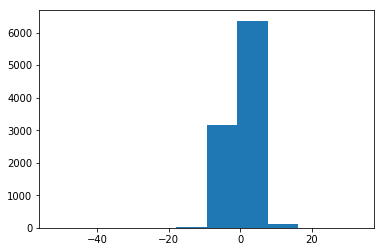

In [248]:
plt.hist(np.round(df_combined['pctChange'],2))

(array([ 224.,  380.,  757., 1215., 1636., 2022., 1298.,  724.,  427.,
         266.]),
 array([-4.99999909, -4.00166044, -3.00332178, -2.00498313, -1.00664448,
        -0.00830583,  0.99003283,  1.98837148,  2.98671013,  3.98504878,
         4.98338744]),
 <a list of 10 Patch objects>)

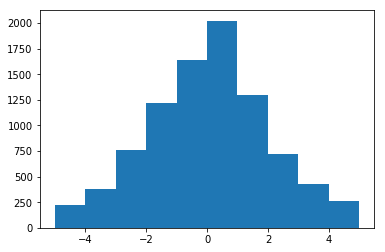

In [249]:
plt.hist(df_combined[(df_combined['pctChange'] > -5) & (df_combined['pctChange'] < 5)]['pctChange'])

In [250]:
df_combined['label'] = 0
df_combined['label'] = (df_combined['pctChange'] >= 1).astype(int)
df_combined['label'] = df_combined['label'].shift(-1)
df_combined

,close,log_return,acceleration,4ema,7ema,14ema,4ema_7ema,4ema_log_return,7ema_log_return,4ema_acceleration,...,3std,6std,6upperBand,6lowerBand,6pctB,PChg6pctB,posit_to_u6BB,posit_tol6BB,label,pctChange
date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.513393,NaN,NaN,0.513393,0.513393,0.513393,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1980-12-15,0.486607,-0.053584,NaN,0.496652,0.498087,0.499043,-0.002885,-0.033152,-0.030267,NaN,...,0.018940,0.018940,0.530305,0.469695,0.279029,NaN,0.085994,-0.035373,0.0,-5.217395
1980-12-16,0.450893,-0.076227,-0.022643,0.473305,0.477679,0.480650,-0.009197,-0.048148,-0.041836,-0.014996,...,0.031356,0.031356,0.533801,0.433461,0.173727,-0.105302,0.168793,-0.039428,1.0,-7.339446
1980-12-17,0.462054,0.024451,0.100678,0.468135,0.471964,0.474961,-0.008148,-0.010985,-0.012035,0.037163,...,0.018271,0.027782,0.522689,0.433785,0.317972,0.144245,0.123305,-0.063133,1.0,2.475245
1980-12-18,0.475446,0.028573,0.004122,0.471306,0.473106,0.475087,-0.003811,0.006752,0.002415,0.017737,...,0.012294,0.024093,0.516227,0.439130,0.471047,0.153076,0.082292,-0.079458,1.0,2.898553
1980-12-19,0.504464,0.059243,0.030669,0.485218,0.482643,0.481885,0.005322,0.029092,0.019958,0.022340,...,0.021680,0.024165,0.520807,0.443479,0.788660,0.317612,0.031882,-0.128847,1.0,6.103282
1980-12-22,0.529018,0.047525,-0.011718,0.503243,0.496022,0.491817,0.014451,0.036474,0.027345,0.007382,...,0.026817,0.028635,0.530563,0.438931,0.983142,0.194483,0.002916,-0.186679,1.0,4.867262
1980-12-23,0.551339,0.041328,-0.006197,0.522810,0.511390,0.503458,0.022085,0.038146,0.030512,0.001672,...,0.023446,0.039579,0.558862,0.432210,0.940604,-0.042538,0.013552,-0.243440,1.0,4.219404
1980-12-24,0.580357,0.051293,0.009965,0.546063,0.530032,0.517617,0.029798,0.043517,0.035804,0.005371,...,0.025742,0.045256,0.589523,0.444703,0.936708,-0.003896,0.015670,-0.266237,1.0,5.263160


In [251]:
train_data = df_combined[5000:8000].drop(columns=['label'])
train_label = df_combined['label'][5000:8000]

test_data = df_combined[8000:].drop(columns=['label'])
test_label= df_combined['label'][8000:]

model = model_Sec(train_data.values.shape[1])
model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adagrad())

In [252]:
from sklearn.metrics import roc_auc_score

class scoreValidation(callbacks.Callback):
    def __init__(self, X_val, y_val):
        super(scoreValidation, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        
    def on_epoch_end(self, epoch, logs={}):
        auc_val = roc_auc_score(to_categorical(self.y_val[:-1].values,2)[:,1:], self.model(self.X_val.values[:-1])[:,1:])    
        print("\nValidation ROC AUC: {}".format(auc_val))  
        
        return

In [253]:
callback = [scoreValidation(test_data, test_label)]
history = model.fit(x=train_data.values, 
                    y=to_categorical(train_label, 2), 
                    validation_data=(test_data.values[:-1], to_categorical(test_label[:-1],2)), 
                    epochs=500, 
                    callbacks=callback)

Train on 3000 samples, validate on 1668 samples
Epoch 1/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.7325
Validation ROC AUC: 0.4840103029079407
3000/3000 [==============================] - 1s 297us/sample - loss: 0.7310 - val_loss: 0.6398
Epoch 2/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6772
Validation ROC AUC: 0.4571742052057013
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6778 - val_loss: 0.7816
Epoch 3/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6622
Validation ROC AUC: 0.4511498999687976
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6619 - val_loss: 0.8379
Epoch 4/500
2976/3000 [============================>.] - ETA: 0s - loss: 0.6582
Validation ROC AUC: 0.4588077422723092
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6579 - val_loss: 0.7551
Epoch 5/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6490
Validation ROC A

Epoch 39/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6248
Validation ROC AUC: 0.5412208089373444
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6259 - val_loss: 0.5714
Epoch 40/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6238
Validation ROC AUC: 0.5404458475324617
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6251 - val_loss: 0.5729
Epoch 41/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6262
Validation ROC AUC: 0.5451792302186003
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6263 - val_loss: 0.5709
Epoch 42/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6289
Validation ROC AUC: 0.5494150061079195
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6293 - val_loss: 0.5667
Epoch 43/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6258
Validation ROC AUC: 0.5457135457135457
3000/3000 [=========

2944/3000 [============================>.] - ETA: 0s - loss: 0.6202
Validation ROC AUC: 0.5551415630155787
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6197 - val_loss: 0.5635
Epoch 78/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6209
Validation ROC AUC: 0.5535549315076874
3000/3000 [==============================] - 0s 167us/sample - loss: 0.6207 - val_loss: 0.5639
Epoch 79/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6225
Validation ROC AUC: 0.553564108682219
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6201 - val_loss: 0.5643
Epoch 80/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6241
Validation ROC AUC: 0.5536670969741836
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6240 - val_loss: 0.5655
Epoch 81/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6249
Validation ROC AUC: 0.5522966389108122
3000/3000 [=======================

2944/3000 [============================>.] - ETA: 0s - loss: 0.6197
Validation ROC AUC: 0.5519988905815677
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6188 - val_loss: 0.5645
Epoch 116/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6199
Validation ROC AUC: 0.550769149194346
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6190 - val_loss: 0.5651
Epoch 117/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6181
Validation ROC AUC: 0.551967280313737
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6183 - val_loss: 0.5643
Epoch 118/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6172
Validation ROC AUC: 0.5523353869810563
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6181 - val_loss: 0.5646
Epoch 119/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6222
Validation ROC AUC: 0.5490030529400608
3000/3000 [====================

2912/3000 [============================>.] - ETA: 0s - loss: 0.6176
Validation ROC AUC: 0.5576663056978018
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6172 - val_loss: 0.5616
Epoch 154/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6178
Validation ROC AUC: 0.5575786126967229
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6186 - val_loss: 0.5614
Epoch 155/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.6166
Validation ROC AUC: 0.5585819837788342
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6186 - val_loss: 0.5607
Epoch 156/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6193
Validation ROC AUC: 0.5560072764797175
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6193 - val_loss: 0.5615
Epoch 157/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6171
Validation ROC AUC: 0.5559226425368157
3000/3000 [==================

2944/3000 [============================>.] - ETA: 0s - loss: 0.6134
Validation ROC AUC: 0.5614248685114828
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6153 - val_loss: 0.5602
Epoch 192/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6144
Validation ROC AUC: 0.5598708669574811
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6140 - val_loss: 0.5617
Epoch 193/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6158
Validation ROC AUC: 0.5584065977766766
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6159 - val_loss: 0.5613
Epoch 194/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6167
Validation ROC AUC: 0.5586737555241492
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6172 - val_loss: 0.5609
Epoch 195/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6177
Validation ROC AUC: 0.5614493409769
3000/3000 [=====================

2944/3000 [============================>.] - ETA: 0s - loss: 0.6154
Validation ROC AUC: 0.5575051953004709
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6152 - val_loss: 0.5620
Epoch 230/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6151
Validation ROC AUC: 0.5573012580886596
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6141 - val_loss: 0.5613
Epoch 231/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6148
Validation ROC AUC: 0.5582230542860465
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6141 - val_loss: 0.5603
Epoch 232/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.6126
Validation ROC AUC: 0.5570341003411869
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6130 - val_loss: 0.5604
Epoch 233/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6150
Validation ROC AUC: 0.5560837529341466
3000/3000 [==================

2944/3000 [============================>.] - ETA: 0s - loss: 0.6119
Validation ROC AUC: 0.5557737683721936
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6113 - val_loss: 0.5639
Epoch 268/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6106
Validation ROC AUC: 0.5571686989009823
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6113 - val_loss: 0.5629
Epoch 269/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6178
Validation ROC AUC: 0.5560796741899103
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6180 - val_loss: 0.5637
Epoch 270/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6120
Validation ROC AUC: 0.5560123749100127
3000/3000 [==============================] - 0s 165us/sample - loss: 0.6129 - val_loss: 0.5624
Epoch 271/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6146
Validation ROC AUC: 0.5564437021129934
3000/3000 [==================

2944/3000 [============================>.] - ETA: 0s - loss: 0.6156
Validation ROC AUC: 0.555145641759815
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6151 - val_loss: 0.5642
Epoch 306/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6158
Validation ROC AUC: 0.5541952943527747
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6158 - val_loss: 0.5641
Epoch 307/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6130
Validation ROC AUC: 0.5544073890530583
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6132 - val_loss: 0.5639
Epoch 308/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6111
Validation ROC AUC: 0.5530471278502775
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6118 - val_loss: 0.5654
Epoch 309/500
2848/3000 [===========================>..] - ETA: 0s - loss: 0.6117
Validation ROC AUC: 0.5553556970879805
3000/3000 [===================

2912/3000 [============================>.] - ETA: 0s - loss: 0.6123
Validation ROC AUC: 0.5523639381907098
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6137 - val_loss: 0.5649
Epoch 344/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6125
Validation ROC AUC: 0.5518642920217723
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6146 - val_loss: 0.5661
Epoch 345/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6104
Validation ROC AUC: 0.5537588687194986
3000/3000 [==============================] - 1s 169us/sample - loss: 0.6101 - val_loss: 0.5653
Epoch 346/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.6137
Validation ROC AUC: 0.5524128831215446
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6137 - val_loss: 0.5659
Epoch 347/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6156
Validation ROC AUC: 0.5527616157537417
3000/3000 [==================

2880/3000 [===========================>..] - ETA: 0s - loss: 0.6142
Validation ROC AUC: 0.5555168074853114
3000/3000 [==============================] - 1s 171us/sample - loss: 0.6149 - val_loss: 0.5627
Epoch 382/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6132
Validation ROC AUC: 0.5566058321963834
3000/3000 [==============================] - 1s 169us/sample - loss: 0.6123 - val_loss: 0.5620
Epoch 383/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6124
Validation ROC AUC: 0.555600421742154
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6117 - val_loss: 0.5630
Epoch 384/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.6090
Validation ROC AUC: 0.5562713751690129
3000/3000 [==============================] - 1s 169us/sample - loss: 0.6114 - val_loss: 0.5617
Epoch 385/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6135
Validation ROC AUC: 0.5574052660666833
3000/3000 [===================

2912/3000 [============================>.] - ETA: 0s - loss: 0.6139
Validation ROC AUC: 0.5532041595033721
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6126 - val_loss: 0.5652
Epoch 420/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6118
Validation ROC AUC: 0.5543951528203497
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6112 - val_loss: 0.5641
Epoch 421/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6144
Validation ROC AUC: 0.5534835534835535
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6140 - val_loss: 0.5646
Epoch 422/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.6141
Validation ROC AUC: 0.5541565462825305
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6138 - val_loss: 0.5643
Epoch 423/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6148
Validation ROC AUC: 0.5549315076874132
3000/3000 [==================

2944/3000 [============================>.] - ETA: 0s - loss: 0.6135
Validation ROC AUC: 0.554874405268106
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6126 - val_loss: 0.5640
Epoch 458/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6094
Validation ROC AUC: 0.5538700144999357
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6103 - val_loss: 0.5644
Epoch 459/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6135
Validation ROC AUC: 0.552965552965553
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6139 - val_loss: 0.5649
Epoch 460/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6072
Validation ROC AUC: 0.5503184479562432
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6090 - val_loss: 0.5671
Epoch 461/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6144
Validation ROC AUC: 0.5511566298967874
3000/3000 [====================

2944/3000 [============================>.] - ETA: 0s - loss: 0.6091
Validation ROC AUC: 0.5549315076874133
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6092 - val_loss: 0.5663
Epoch 496/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6113
Validation ROC AUC: 0.5552843190638467
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6118 - val_loss: 0.5659
Epoch 497/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6125
Validation ROC AUC: 0.5555147681131933
3000/3000 [==============================] - 1s 169us/sample - loss: 0.6112 - val_loss: 0.5651
Epoch 498/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6102
Validation ROC AUC: 0.5560450048639025
3000/3000 [==============================] - 0s 166us/sample - loss: 0.6104 - val_loss: 0.5639
Epoch 499/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6106
Validation ROC AUC: 0.553147057084065
3000/3000 [===================

Sell Side

In [256]:
df_combined['label'] = 0
df_combined['label'] = (df_combined['pctChange'] <= -1).astype(int)
df_combined['label'] = df_combined['label'].shift(-1)

train_data = df_combined[5000:8000].drop(columns=['label'])
train_label = df_combined['label'][5000:8000]

test_data = df_combined[8000:].drop(columns=['label'])
test_label= df_combined['label'][8000:]

model = model_Sec(train_data.values.shape[1])
model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adagrad())


In [257]:
callback = [scoreValidation(test_data, test_label)]
history = model.fit(x=train_data.values, 
                    y=to_categorical(train_label, 2), 
                    validation_data=(test_data.values[:-1], to_categorical(test_label[:-1],2)), 
                    epochs=500, 
                    callbacks=callback)

Train on 3000 samples, validate on 1668 samples
Epoch 1/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.7407
Validation ROC AUC: 0.5436065762575221
3000/3000 [==============================] - 1s 300us/sample - loss: 0.7384 - val_loss: 0.4898
Epoch 2/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6579
Validation ROC AUC: 0.5368354879886365
3000/3000 [==============================] - 1s 167us/sample - loss: 0.6580 - val_loss: 0.4971
Epoch 3/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.6363
Validation ROC AUC: 0.526551687733341
3000/3000 [==============================] - 1s 168us/sample - loss: 0.6367 - val_loss: 0.5068
Epoch 4/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6272
Validation ROC AUC: 0.5241402973328343
3000/3000 [==============================] - 0s 167us/sample - loss: 0.6276 - val_loss: 0.5306
Epoch 5/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.6151
Validation ROC AU

Epoch 39/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5833
Validation ROC AUC: 0.525169637115737
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5826 - val_loss: 0.5308
Epoch 40/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5761
Validation ROC AUC: 0.5240947088576008
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5783 - val_loss: 0.5292
Epoch 41/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5786
Validation ROC AUC: 0.5217744954075609
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5787 - val_loss: 0.5258
Epoch 42/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5766
Validation ROC AUC: 0.524421026364535
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5763 - val_loss: 0.5315
Epoch 43/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5780
Validation ROC AUC: 0.5227654448955303
3000/3000 [===========

2912/3000 [============================>.] - ETA: 0s - loss: 0.5780
Validation ROC AUC: 0.5358853281890339
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5784 - val_loss: 0.5319
Epoch 78/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5750
Validation ROC AUC: 0.5338338468035281
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5756 - val_loss: 0.5234
Epoch 79/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.5745
Validation ROC AUC: 0.5350143483727314
3000/3000 [==============================] - 1s 170us/sample - loss: 0.5765 - val_loss: 0.5257
Epoch 80/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5735
Validation ROC AUC: 0.5364971735145355
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5738 - val_loss: 0.5220
Epoch 81/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5752
Validation ROC AUC: 0.5372793757738044
3000/3000 [======================

2848/3000 [===========================>..] - ETA: 0s - loss: 0.5693
Validation ROC AUC: 0.5407968865470809
3000/3000 [==============================] - 1s 170us/sample - loss: 0.5703 - val_loss: 0.5281
Epoch 116/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5726
Validation ROC AUC: 0.5413283521925657
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5714 - val_loss: 0.5173
Epoch 117/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.5737
Validation ROC AUC: 0.5410488228575816
3000/3000 [==============================] - 1s 171us/sample - loss: 0.5755 - val_loss: 0.5197
Epoch 118/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5739
Validation ROC AUC: 0.5408592707763478
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5731 - val_loss: 0.5209
Epoch 119/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5720
Validation ROC AUC: 0.5427667885558531
3000/3000 [==================

Epoch 153/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5690
Validation ROC AUC: 0.5482110122561017
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5703 - val_loss: 0.5175
Epoch 154/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5693
Validation ROC AUC: 0.549533078037872
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5682 - val_loss: 0.5195
Epoch 155/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5721
Validation ROC AUC: 0.5473616269806993
3000/3000 [==============================] - 0s 164us/sample - loss: 0.5709 - val_loss: 0.5208
Epoch 156/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5695
Validation ROC AUC: 0.5460011709039955
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5718 - val_loss: 0.5281
Epoch 157/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5759
Validation ROC AUC: 0.5473088403251658
3000/3000 [=====

Epoch 191/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5707
Validation ROC AUC: 0.5460587563463957
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5718 - val_loss: 0.5189
Epoch 192/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5688
Validation ROC AUC: 0.5469705258510649
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5703 - val_loss: 0.5272
Epoch 193/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5705
Validation ROC AUC: 0.546780973769831
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5713 - val_loss: 0.5235
Epoch 194/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5703
Validation ROC AUC: 0.5490747938921041
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5704 - val_loss: 0.5217
Epoch 195/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5642
Validation ROC AUC: 0.5528466403693146
3000/3000 [=====

Epoch 229/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5716
Validation ROC AUC: 0.55356885779275
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5694 - val_loss: 0.5125
Epoch 230/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5683
Validation ROC AUC: 0.553957559528951
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5673 - val_loss: 0.5123
Epoch 231/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5693
Validation ROC AUC: 0.5561002178649237
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5697 - val_loss: 0.5078
Epoch 232/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5715
Validation ROC AUC: 0.5551452592784544
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5693 - val_loss: 0.5102
Epoch 233/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5696
Validation ROC AUC: 0.5550204908199208
3000/3000 [=======

Epoch 267/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5716
Validation ROC AUC: 0.5521532156670793
3000/3000 [==============================] - 0s 165us/sample - loss: 0.5712 - val_loss: 0.5234
Epoch 268/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5671
Validation ROC AUC: 0.5529018264182815
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5668 - val_loss: 0.5138
Epoch 269/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5672
Validation ROC AUC: 0.5514525927845441
3000/3000 [==============================] - 0s 165us/sample - loss: 0.5686 - val_loss: 0.5171
Epoch 270/500
2784/3000 [==========================>...] - ETA: 0s - loss: 0.5676
Validation ROC AUC: 0.5508119547378423
3000/3000 [==============================] - 1s 174us/sample - loss: 0.5665 - val_loss: 0.5214
Epoch 271/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5652
Validation ROC AUC: 0.5528586373364813
3000/3000 [====

Epoch 305/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5660
Validation ROC AUC: 0.5551860489668212
3000/3000 [==============================] - 1s 170us/sample - loss: 0.5636 - val_loss: 0.5077
Epoch 306/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5673
Validation ROC AUC: 0.5555627537358556
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5655 - val_loss: 0.5133
Epoch 307/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5670
Validation ROC AUC: 0.5565561026172583
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5670 - val_loss: 0.5090
Epoch 308/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.5681
Validation ROC AUC: 0.5560558290864069
3000/3000 [==============================] - 1s 170us/sample - loss: 0.5661 - val_loss: 0.5078
Epoch 309/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5671
Validation ROC AUC: 0.554027141938518
3000/3000 [=====

Epoch 343/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5710
Validation ROC AUC: 0.5566640753217587
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5699 - val_loss: 0.5127
Epoch 344/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5684
Validation ROC AUC: 0.5592050329676658
3000/3000 [==============================] - 0s 167us/sample - loss: 0.5675 - val_loss: 0.5077
Epoch 345/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5654
Validation ROC AUC: 0.5595505456220667
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5640 - val_loss: 0.5110
Epoch 346/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5669
Validation ROC AUC: 0.558585989461864
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5667 - val_loss: 0.5093
Epoch 347/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5596
Validation ROC AUC: 0.5586003858224641
3000/3000 [=====

Epoch 381/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5648
Validation ROC AUC: 0.5571775455164935
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5631 - val_loss: 0.5065
Epoch 382/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5637
Validation ROC AUC: 0.556652078354592
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5624 - val_loss: 0.5108
Epoch 383/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5678
Validation ROC AUC: 0.5570215849433263
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5672 - val_loss: 0.5072
Epoch 384/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5591
Validation ROC AUC: 0.553463284481683
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5625 - val_loss: 0.5098
Epoch 385/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5666
Validation ROC AUC: 0.5528514391561813
3000/3000 [======

Epoch 419/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5654
Validation ROC AUC: 0.5545718042478861
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5672 - val_loss: 0.5052
Epoch 420/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5630
Validation ROC AUC: 0.5561002178649237
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5653 - val_loss: 0.5072
Epoch 421/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5636
Validation ROC AUC: 0.557055176451393
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5628 - val_loss: 0.5063
Epoch 422/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5618
Validation ROC AUC: 0.5564961177814248
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5639 - val_loss: 0.5091
Epoch 423/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5659
Validation ROC AUC: 0.5567528528787922
3000/3000 [=====

Epoch 457/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5658
Validation ROC AUC: 0.5563161632739244
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5650 - val_loss: 0.5064
Epoch 458/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5654
Validation ROC AUC: 0.5555075676868887
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5677 - val_loss: 0.5052
Epoch 459/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5645
Validation ROC AUC: 0.5543054715767854
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5647 - val_loss: 0.5069
Epoch 460/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5622
Validation ROC AUC: 0.5545694048544527
3000/3000 [==============================] - 1s 170us/sample - loss: 0.5613 - val_loss: 0.5064
Epoch 461/500
2880/3000 [===========================>..] - ETA: 0s - loss: 0.5635
Validation ROC AUC: 0.5551980459339879
3000/3000 [====

Epoch 495/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5632
Validation ROC AUC: 0.5577641972109451
3000/3000 [==============================] - 1s 168us/sample - loss: 0.5635 - val_loss: 0.5157
Epoch 496/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5622
Validation ROC AUC: 0.5587755415430979
3000/3000 [==============================] - 1s 167us/sample - loss: 0.5631 - val_loss: 0.5154
Epoch 497/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5671
Validation ROC AUC: 0.5590610693616653
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5681 - val_loss: 0.5108
Epoch 498/500
2944/3000 [============================>.] - ETA: 0s - loss: 0.5619
Validation ROC AUC: 0.5594161795897996
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5636 - val_loss: 0.5054
Epoch 499/500
2912/3000 [============================>.] - ETA: 0s - loss: 0.5668
Validation ROC AUC: 0.5585428003800639
3000/3000 [====

In [ ]:
history.history